# Detecting Depression through NLP and DL

1. Evelyn Peh Ting Yu
2. Koh Pei Ling
3. Lau Wei Ting
4. Song Yu Xiang
5. Jian Yi
6. Luqman Juzaili

In [2]:
#!pip install transformers==3.0.0

In [3]:
#pip install transformers

In [4]:
#pip install torchvision 

In [5]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

In [6]:
#pip install pandas#!pip install transformers==3.0.0

#pip install transformers

#pip install torchvision 

# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
#pip install matplotlib
#pip install seaborn
#pip install nltk
#nltk.download('stopwords')
#pip install wordcloud
#pip install scikit-learn

# pip install emoji-unicode
# pip install emoji --upgrade
# pip uninstall emoji
# pip install emoji==1.7

#pip install imblearn

## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

# Natural language Processing
import re
import nltk
stop=nltk.corpus.stopwords.words('english')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Emoji
import emoji
from emoji import UNICODE_EMOJI
from nltk.tokenize.casual import TweetTokenizer

# Scikit Learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

from collections import defaultdict
from collections import Counter

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.cuda.amp import autocast, GradScaler
torch.cuda.amp.autocast(enabled=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import time

In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.get_option('max_colwidth')
pd.set_option('max_colwidth', 500)

<hr>

## 2. Import Datasets

<strong> Dataset 1 </strong>

This dataset comprises around 10.1k dataset extracted from Twitter. It consists of 3 columns. The id, tweets and the labels with 1 indicating the person is suffering from depression and 0   for the inverse. Source: https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets

<strong> Dataset 2 </strong>

This dataset comprises around 20k data extracted from Twitter. It consists of information with regards to the post itself: Post_Text, Post_date, Number of retweets, favourites, and have a label as well. Source: https://www.kaggle.com/datasets/infamouscoder/mental-health-social-media?select=Mental-Health-Twitter.csv

In [9]:
df1 = pd.read_csv("sentiment_tweets3.csv")
df2 = pd.read_csv("Mental-Health-Twitter.csv")  # dataset consist of emoji

In [10]:
df1.head()

,Index,message to examine,label (depression result)
0,106,"just had a real good moment. i missssssssss him so much,",0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
3,288,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [11]:
df1.rename(columns={'message to examine':"Message"},inplace=True)
df1.rename(columns={'label (depression result)':"Label"},inplace=True)

In [12]:
df1.columns

Index(['Index', 'Message', 'Label'], dtype='object')

In [13]:
df1.drop(["Index"],inplace=True,axis=1)

In [14]:
df1.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zoGfqvh2ME8,0
3,"@lapcat Need to send 'em to my accountant tomorrow. Oddly, I wasn't even referring to my taxes. Those are supporting evidence, though.",0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [15]:
df2.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain has other ideas...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety,1013187241,84,211,251,837,1,1


In [16]:
df2.drop(columns=["Unnamed: 0", "post_id", "post_created","user_id",'followers', 'friends', 'favourites', 'statuses', 'retweets'], inplace=True)

In [17]:
df2.rename(columns={"post_text": "Message"}, inplace=True)
df2.rename(columns={"label": "Label"}, inplace=True)

In [18]:
df2.head()

,Message,Label
0,It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.,1
1,"It's Sunday, I need a break, so I'm planning to spend as little time as possible on the #A14...",1
2,Awake but tired. I need to sleep but my brain has other ideas...,1
3,RT @SewHQ: #Retro bears make perfect gifts and are great for beginners too! Get stitching with October's Sew on sale NOW! #yay http://t.co/…,1
4,It’s hard to say whether packing lists are making life easier or just reinforcing how much still needs doing... #movinghouse #anxiety,1


###### Merge dataset

In [19]:
df_uncleaned = pd.concat([df1,df2])

In [20]:
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30314 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  30314 non-null  object
 1   Label    30314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 710.5+ KB


In [21]:
df_uncleaned.shape

(30314, 2)

###### Check for null and duplicate

In [22]:
df_uncleaned.duplicated().sum()

543

In [23]:
df_uncleaned.drop_duplicates(inplace=True)

In [24]:
df_uncleaned.shape

(29771, 2)

In [25]:
##Checking for null values
df_uncleaned.isnull().sum()

Message    0
Label      0
dtype: int64

In [26]:
df_uncleaned.columns

Index(['Message', 'Label'], dtype='object')

In [27]:
df_uncleaned.sample(10)

,Message,Label
2782,2 shots of goose ! Good to go For NOw,0
14989,I'm sorry. I always laugh at the same jokes constantly.,0
6610,RT @CNN: The winter storm dumped nearly 3 feet of snow with Massachusetts getting buried the deepest: http://t.co/ZS4kWdC1mw http://t.co/Lr…,1
1696,@Michilais topi!!! u're back!!,0
8979,"@MissLusyd don't get too hammered, mmkay?",1
366,@moonfrye THAT WOULD BE MY SON! WITHOUT A DOUBT! HE'S 12 YEARS OLD AND THE AIR THAT I BREATHE &amp; THE LOVE OF MY LIFE!,0
2811,"Just got home, sleep time",0
1592,5 more days of work till SUMMER VACATION!! One of only a few perks to being a teacher!!,0
17749,@MaddyTran1 Finally!!!,0
3498,"""@selfharming5: I'm sorry http://t.co/MOqdSOKn""",1


<hr>

## 2. Exploratory Data Analysis

###### Target Class Distribution

> imbalance dataset with 59% non-depressive, 41% depressive

In [28]:
df_uncleaned.Label.value_counts(normalize = True)

0    0.590037
1    0.409963
Name: Label, dtype: float64

<AxesSubplot:xlabel='Label', ylabel='count'>

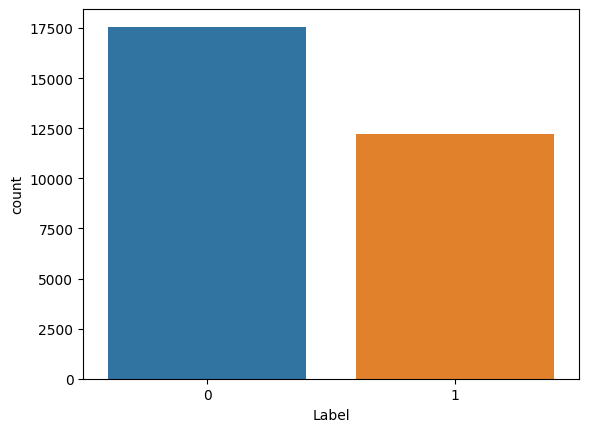

In [29]:
sns.countplot(x=df_uncleaned["Label"])

###### Number of characters in tweets

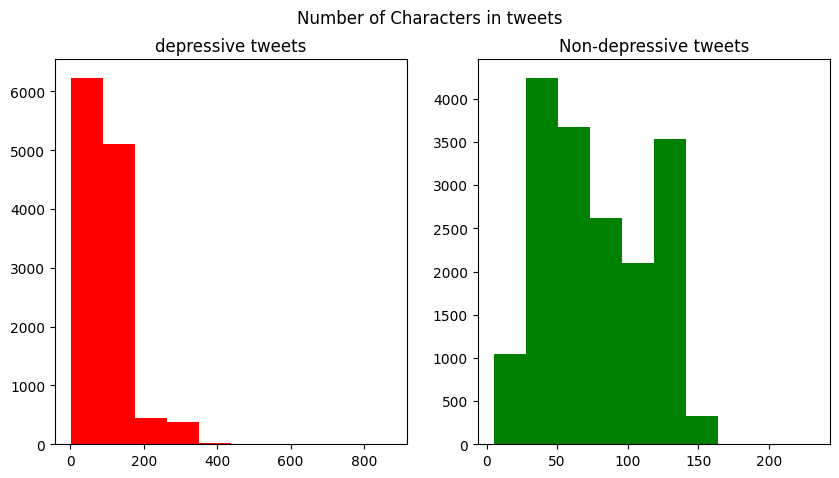

In [30]:
## Number of character
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Number of Characters in tweets')

#depressive
tweet_len=df_uncleaned[df_uncleaned['Label']==1]['Message'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('depressive tweets')

#non-depressive
tweet_len=df_uncleaned[df_uncleaned['Label']==0]['Message'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Non-depressive tweets')

plt.show()

##### Common stopwords in tweets

> In both of classes, "the", "to", "a" dominates 

In [31]:
def create_corpus(target):
    corpus=[]
    
    for x in df_uncleaned[df_uncleaned['Label']==target]['Message'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

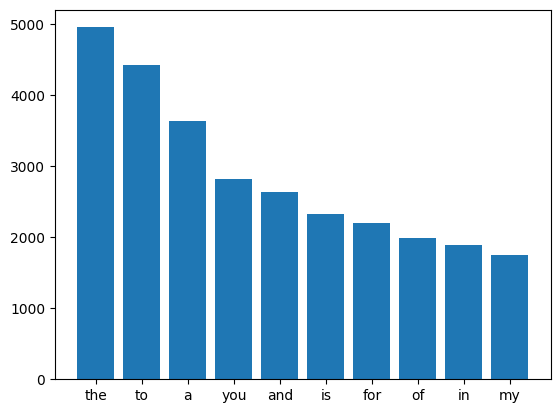

In [32]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

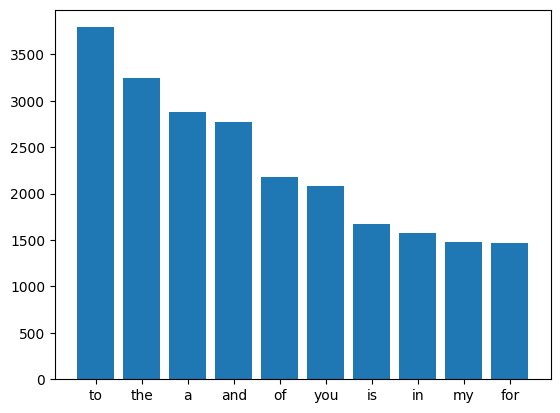

In [33]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

##### Number of Stop Words in a sentence on average 


In [34]:
# This will return us the percentage of Stop Words in Each Tweet. 

percentage_of_stop_word_in_each_tweet = []

def percentage_of_stop_word():
    for x in df_uncleaned['Message']:
        stop_word = 0.0
        total_word_per_sentence = 0.0
        for each_word in x.split(" "):
            if each_word in stop:
                stop_word += 1
            total_word_per_sentence += 1
        
        percentage_of_stop_word_in_each_tweet.append(stop_word/total_word_per_sentence)
    

percentage_of_stop_word()


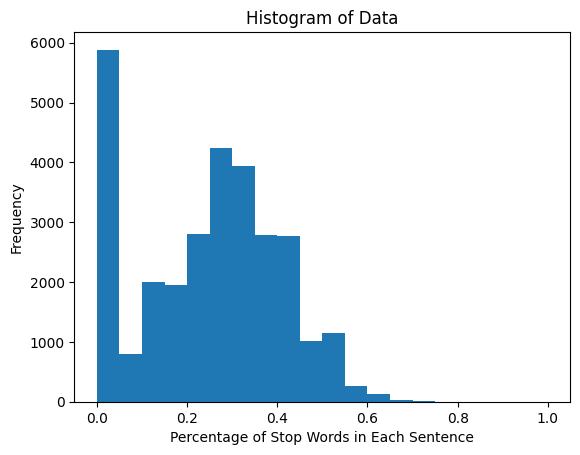

In [35]:
import matplotlib.pyplot as plt

data = percentage_of_stop_word_in_each_tweet

# Create a histogram with 0.05 bin width
bins = list(map(lambda x: x / 20, range(21)))
plt.hist(data, bins=bins)

# Add labels and title
plt.xlabel('Percentage of Stop Words in Each Sentence')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Show the histogram
plt.show()


##### Common punctuation in tweets

<BarContainer object of 25 artists>

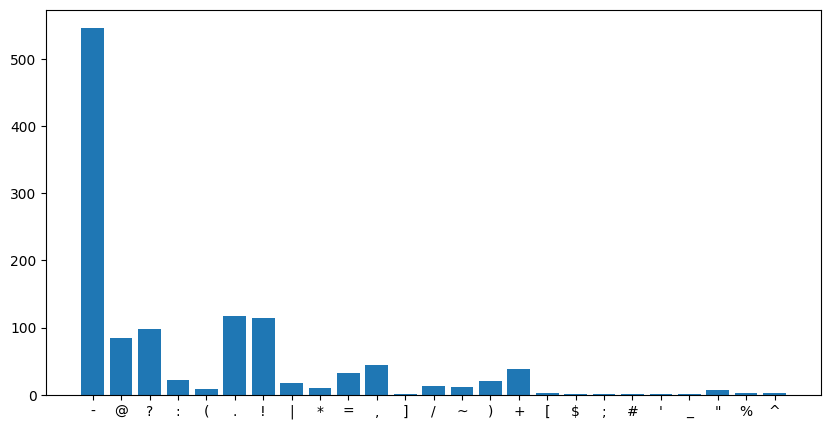

In [36]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 23 artists>

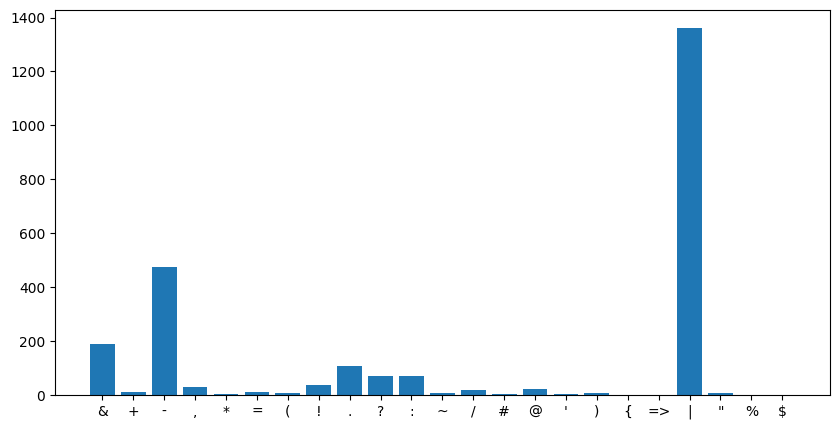

In [37]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

##### Common Words

> it can be see that the common words are stop words which implies that data cleaning is neccessary

In [38]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

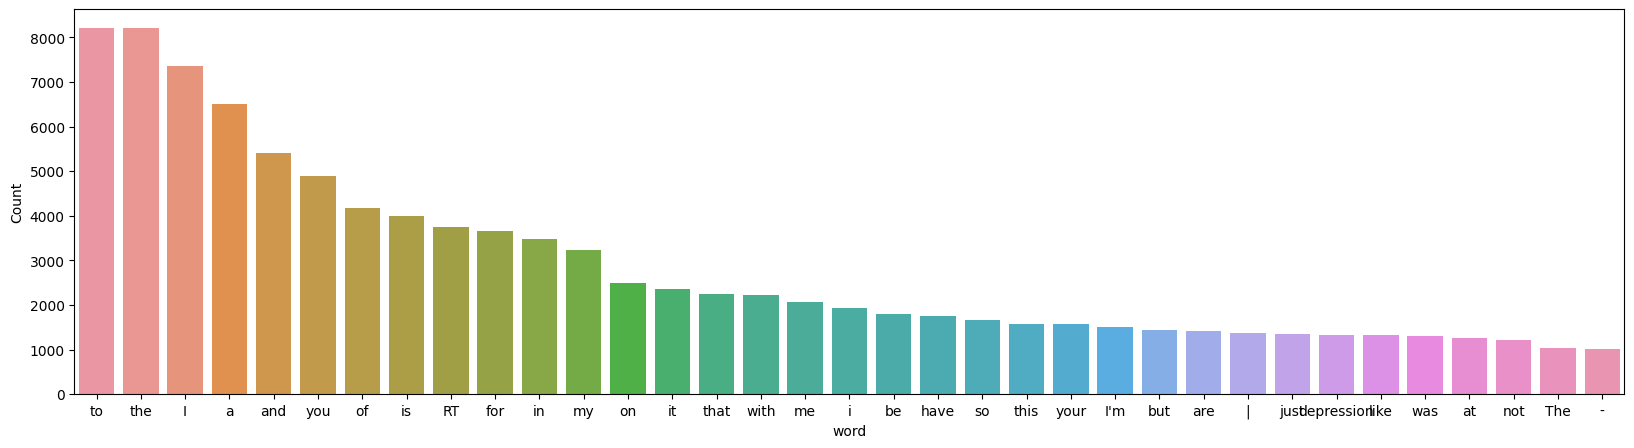

In [39]:
freq_words(df_uncleaned['Message'], 35)

###### Common Words - Bi-Gram Analysis

Bigram (n=2) analysis over the tweets to check the most common bigrams in tweets.

In [40]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

> The most frequent words are often unimportant words such as https which is an internet protocol and other words that does not echo much meaning for people identified with depression. Therefore, there is a need of thorough data cleaning 


<AxesSubplot:>

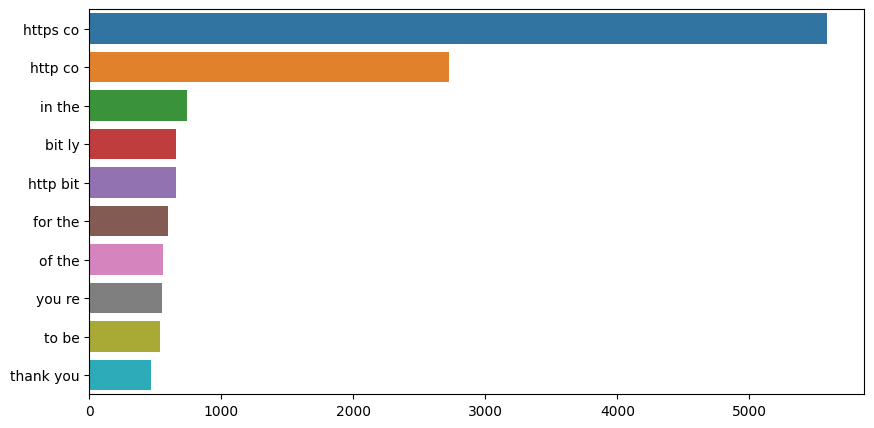

In [41]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df_uncleaned['Message'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#### Word Cloud Visualization

Depression Class

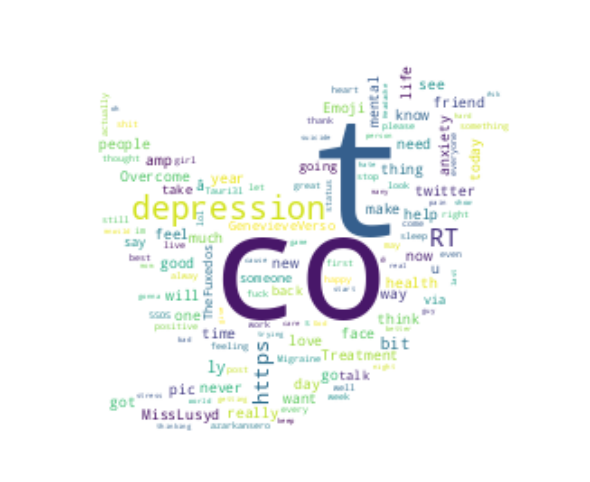

In [42]:
depressive_words = ' '.join(list(df_uncleaned[df_uncleaned['Label'] == 1]['Message']))
mask = np.array(Image.open("Twitter.png"))
depressive_wc = WordCloud(collocations=False, mask=mask, background_color="white").generate(depressive_words)
plt.figure(figsize = (8, 6))
plt.imshow(depressive_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Non-Depression Class

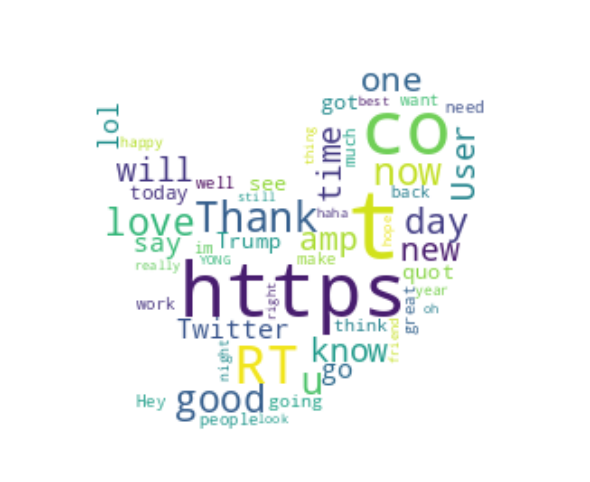

In [43]:
nondepressive_words = ' '.join(list(df_uncleaned[df_uncleaned['Label'] == 0]['Message']))
mask = np.array(Image.open("Twitter.png"))
nondepressive_wc = WordCloud(collocations=False, mask=mask, background_color="white").generate(nondepressive_words)
plt.figure(figsize = (8, 6))
plt.imshow(nondepressive_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Data Cleaning

In [44]:
## Remerge the data after dropping all RT in the 2nd data set -- substr = "RT @" 
df2 = df2[~df2.Message.str.contains("RT @")]
df_uncleaned = pd.concat([df1,df2])

In [45]:
df_uncleaned.shape

(26609, 2)

###### Convert to Lower Case 

In [46]:
def text_to_lower(text):
    text = text.lower()
    return text

In [47]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:text_to_lower(x))

In [48]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of HTML entities 

In [49]:
# These are the HTML Entities 
html_entities = {'&nbsp;': '', '&iexcl;': '', '&cent;': '', '&pound;': '', '&curren;': '', '&yen;': '', '&brvbar;': '', 
                  '&sect;': '', '&uml;': '', '&copy;': '', '&reg;': '', '&trade;': '', '&macr;': '', '&deg;': '', 
                  '&plusmn;': '', '&sup2;': '', '&sup3;': '', '&acute;': '', '&micro;': '', '&para;': '', '&middot;': '', 
                  '&cedil;': '', '&sup1;': '', '&ordm;': '', '&raquo;': '', '&frac14;': '', '&frac12;': '', '&frac34;': '', 
                  '&iquest;': '', '&Agrave;': '', '&Aacute;': '', '&Acirc;': '', '&Atilde;': '', '&Auml;': '', 
                  '&Aring;': '', '&AElig;': '', '&Ccedil;': '', '&Egrave;': '', '&Eacute;': '', '&Ecirc;': '', '&Euml;': '', 
                  '&Igrave;': '', '&Iacute;': '', '&Icirc;': '', '&Iuml;': '', '&ETH;': '', '&Ntilde;': '', '&Ograve;': '', 
                  '&Oacute;': '', '&Ocirc;': '', '&Otilde;': '', '&Ouml;': '', '&times;': '', '&Oslash;': '', 
                  '&Ugrave;': '', '&Uacute;': '', '&Ucirc;': '', '&Uuml;': '', '&Yacute;': '', '&THORN;': '', '&szlig;': '', 
                  '&agrave;': '', '&aacute;': '', '&acirc;': '', '&atilde;': '', '&auml;': '', '&aring;': '', '&aelig;': '', 
                  '&ccedil;': '', '&egrave;': '', '&eacute;': '', '&ecirc;': '', '&euml;': '', '&igrave;': '', '&iacute;': '', 
                  '&icirc;': '', '&iuml;': '', '&eth;': '', '&ntilde;': '', '&ograve;': '', '&oacute;': '', '&ocirc;': '', 
                  '&otilde;': '', '&ouml;': '', '&divide;': '','&amp;': '', '&lt;': '', '&gt;': '', '&quot;': '', '&apos;': ''}

In [50]:
html_re = re.compile('(%s)' % '|'.join(html_entities.keys()))

def replace_html_entities(text,contractions_dict=html_entities):
    def replace(match):
        return html_entities[match.group(0)]
    return html_re.sub(replace, text)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:replace_html_entities(x))


In [51]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Hashtags

In [52]:
# Removal of HashTag
def remove_hashtags (text):
    text = re.sub(r"#\w+", '', text, flags=re.MULTILINE)
    return(text)


In [53]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_hashtags(x))

In [54]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss him so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i wasn't even referring to my taxes. those are supporting evidence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Conversion of contractions

In [55]:
# Converting it to string type
df_uncleaned['Message'] = df_uncleaned['Message'].astype("str")
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26609 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Message  26609 non-null  object
 1   Label    26609 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 623.6+ KB


In [56]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have",
                    
                    "aint": "are not","'s":" is","arent": "are not",
                     "cant": "cannot","cantve": "cannot have",
                     "'cause": "because","couldve": "could have","couldnt": "could not",
                     "couldntve": "could not have", "didnt": "did not","doesnt": "does not",
                     "dont": "do not","hadnt": "had not","hadnt've": "had not have",
                     "hasnt": "has not","havent": "have not","hed": "he would",
                     "hedve": "he would have","hell": "he will", "hellve": "he will have",
                     "howd": "how did","howdy": "how do you","howll": "how will",
                     "id": "i would", "id've": "i would have","ill": "i will",
                     "illve": "i will have","im": "i am","ive": "i have", "isnt": "is not",
                     "itd": "it would","itd've": "it would have","itll": "it will",
                     "itll've": "it will have", "lets": "let us","maam": "madam",
                     "maynt": "may not","mightve": "might have","mightnt": "might not", 
                     "mightntve": "might not have","mustve": "must have","mustnt": "must not",
                     "mustn'tve": "must not have", "neednt": "need not",
                     "needn'tve": "need not have","oclock": "of the clock","oughtnt": "ought not",
                     "oughtntve": "ought not have","shant": "shall not","shant": "shall not",
                     "shantve": "shall not have","shed": "she would","shedve": "she would have",
                     "shell": "she will", "shellve": "she will have","shouldve": "should have",
                     "shouldnt": "should not", "shouldntve": "should not have","sove": "so have",
                     "thatd": "that would","thatdve": "that would have", "thered": "there would",
                     "theredve": "there would have", "theyd": "they would",
                     "theydve": "they would have","theyll": "they will",
                     "theyllve": "they will have", "theyre": "they are","theyve": "they have",
                     "tove": "to have","wasnt": "was not","wed": "we would",
                     "wedve": "we would have","well": "we will","well've": "we will have",
                     "were": "we are","weve": "we have", "werent": "were not","whatll": "what will",
                     "whatllve": "what will have","whatre": "what are", "whatve": "what have",
                     "whenve": "when have","whered": "where did", "whereve": "where have",
                     "wholl": "who will","whollve": "who will have","whove": "who have",
                     "whyve": "why have","willve": "will have","wont": "will not",
                     "wontve": "will not have", "wouldve": "would have","wouldnt": "would not",
                     "wouldntve": "would not have","yall": "you all", "yalld": "you all would",
                     "yalldve": "you all would have","yallre": "you all are",
                     "yallve": "you all have", "youd": "you would","youdve": "you would have",
                     "youll": "you will","youllve": "you will have", "youre": "you are",
                     "youve": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

In [57]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:expand_contractions(x))

In [58]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http://www.youtube.com/watch?v=zogfqvh2me8,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of URL

In [59]:
def remove_urls (text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return(text)

In [60]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_urls(x))

In [61]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga,0
2,@comeagainjen -,0
3,"@lapcat need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Mentions/Retweets User Accounts 

In [62]:
def remove_mentions_user (text):
    text = re.sub(r"@\w+", '', text, flags=re.MULTILINE)
    return(text)

In [63]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_mentions_user(x))

In [64]:
df_uncleaned.head()

,Message,Label
0,"just had a real good moment. i missssssssss hi am so much,",0
1,is reading manga,0
2,-,0
3,"need to send 'em to my accountant tomorrow. oddly, i was not even referring to my taxes. those are supporting evi wouldence, though.",0
4,add me on myspace!!! myspace.com/lookthunder,0


###### Removal of Punctuation

In [65]:
def remove_punctuations (text):
    text = re.sub(r"""[!"¦#$%&\'()*+,-./:;<=>?@[\\\]^_`{|}~،؟…«“\":\"…”]""", '', text, flags=re.MULTILINE)
    return(text)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:remove_punctuations(x))

In [66]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Removal of numbers

In [67]:
df_uncleaned['Message'] = df_uncleaned['Message'].str.replace('\d+', '')

/common/home/users/j/jianyi.lye.2020/jupyterlab-venv-tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [68]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Emojis to textual description conversion

Translate emojis to their textual description. This is to ensure that the sentiment value that an emoji contain will also be considered by the model in future parts.
- Utilise TweetTokenizer to split tweets on a list of words, while treating the emoji as a word itself.
- Utilise Emoji demojize to convert the graphical representation of the emoji to its textual representation which seperated by underscore when the description is more than 1 word e.g., smiling_beaming_face, tears_of_joy
- Seperate the textual description of emojis e.g, "smiling_beaming_face" as ['smiling','beaming','face'] to consider it as normal words

#### Need to choose one method (How do we store emoji textual description)

In [69]:
# helper function for convert_emojis; return true if token is an emoji
def is_emoji(s):
    return s in UNICODE_EMOJI

# Break up sentences into list of words while considering emojis
def store_emojis(text):
    
    # break up tweets into words while considering emojis as itself e.g., ['this','is','cool','😁','👍']
    tweet_list = TweetTokenizer().tokenize(text)
    tweet_string = convert_emojis(tweet_list)
    return tweet_string

def convert_emojis(text):
    new_text = []
    
    for i in range(len(text)):
        if is_emoji(text[i]):
            temp = emoji.demojize(text[i], delimiters=("",""))
            
            if "_" in temp:
                temp = temp.split("_")
            
            for item in temp:
                new_text.append(item)
        else:
            new_text.append(text[i])
        
    return ' '.join([str(item) for item in new_text])

In [70]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x:store_emojis(x))

In [71]:
df_uncleaned.head()

,Message,Label
0,just had a real good moment i missssssssss hi am so much,0
1,is reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddly i was not even referring to my taxes those are supporting evi wouldence though,0
4,add me on myspace myspacecomlookthunder,0


###### Removal of StopWords 


In [72]:
stopWords = set(stopwords.words('english'))

In [73]:
from string import printable
st = set(printable)
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x: ''.join([" " if  i not in  st else i for i in x]))

In [74]:
import nltk 
def remove_stopwords(paragraph):
    words = nltk.word_tokenize(paragraph)
    wordlist_wo_stopwords=[]
    for w in words:
        if w not in stopWords:
            wordlist_wo_stopwords.append(w)
    return wordlist_wo_stopwords

df_uncleaned['Message'] = df_uncleaned['Message'].astype(str)
df_uncleaned['Message'] = df_uncleaned['Message'].str.replace('[^a-zA-Z0-9]', ' ', regex=True).str.strip()
df_uncleaned['Message'] = df_uncleaned['Message'].apply(remove_stopwords)

In [75]:
df_uncleaned['Message'] = df_uncleaned['Message'].apply(lambda x: ' '.join(x))

In [76]:
df_uncleaned.head()

,Message,Label
0,real good moment missssssssss hi much,0
1,reading manga,0
2,,0
3,need send em accountant tomorrow oddly even referring taxes supporting evi wouldence though,0
4,add myspace myspacecomlookthunder,0


###### Tokenisation 

Remove Stop words first then tokenise
- What is tokenization? In essence, it’s splitting a string into smaller units (tokens) 

- After tokenizing the sentence we are provided with a list of all words (and signs) within the sentence. Another common method is sentence tokenization, which splits the text into a list of sentences --> i think maybe no need 

https://www.dataquest.io/blog/how-to-clean-and-prepare-your-data-for-analysis/

In [77]:
# nltk.download('punkt')

In [78]:
df_uncleaned['Tokenised'] = df_uncleaned['Message'].apply(word_tokenize)

In [79]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment missssssssss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even referring taxes supporting evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


###### Lemmatization
Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning.

In [80]:
#nltk.download('averaged_perceptron_tagger')

In [81]:
#nltk.download('all')

In [82]:
lemmatizer = WordNetLemmatizer()

def lemmatize_it(text):
    empty = []
    for word, tag in pos_tag(word_tokenize(text)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
            empty.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, wntag)
            empty.append(lemma)
    return ' '.join(empty)

df_uncleaned['Message'] = df_uncleaned['Message'].apply(lemmatize_it)

In [83]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment miss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


<hr>

### 4. Exploratory Data Analysis on Cleaened Dataset

> Getting the most popular words for the whole dataset

In [84]:
# function for checking popular words:
def popular_words(series):
    top = Counter([item for sublist in df_uncleaned['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned['Message'])

,Common_words,count
0,depression,2965
1,would,2140
2,like,1353
3,good,1042
4,ame,995
5,ti,994
6,get,976
7,love,954
8,one,932
9,know,902


**Insights**: We are able to observe the top 20 most common words in the dataset. This will provide us with insights of what words are more significant than the others in detecting depression. More specifically, we will be interested to know how many of these words are from depressed labelled tweets.

> Getting the most popular words for the whole dataset for depressed labelled tweets

In [85]:
df_uncleaned.shape

(26609, 3)

In [86]:
df_uncleaned_depressed = df_uncleaned[df_uncleaned["Label"] == 1] 
df_uncleaned_depressed.shape

(10495, 3)

In [87]:
from collections import Counter

# function for checking popular words in depressed labels:
def popular_words(series):
#     data1['temp_list'] = series.apply(lambda x:str(x).split())
    top = Counter([item for sublist in df_uncleaned_depressed['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned_depressed['Message'])

,Common_words,count
0,depression,2961
1,would,843
2,like,619
3,get,450
4,people,398
5,ti,386
6,one,386
7,know,374
8,anxiety,364
9,ame,337


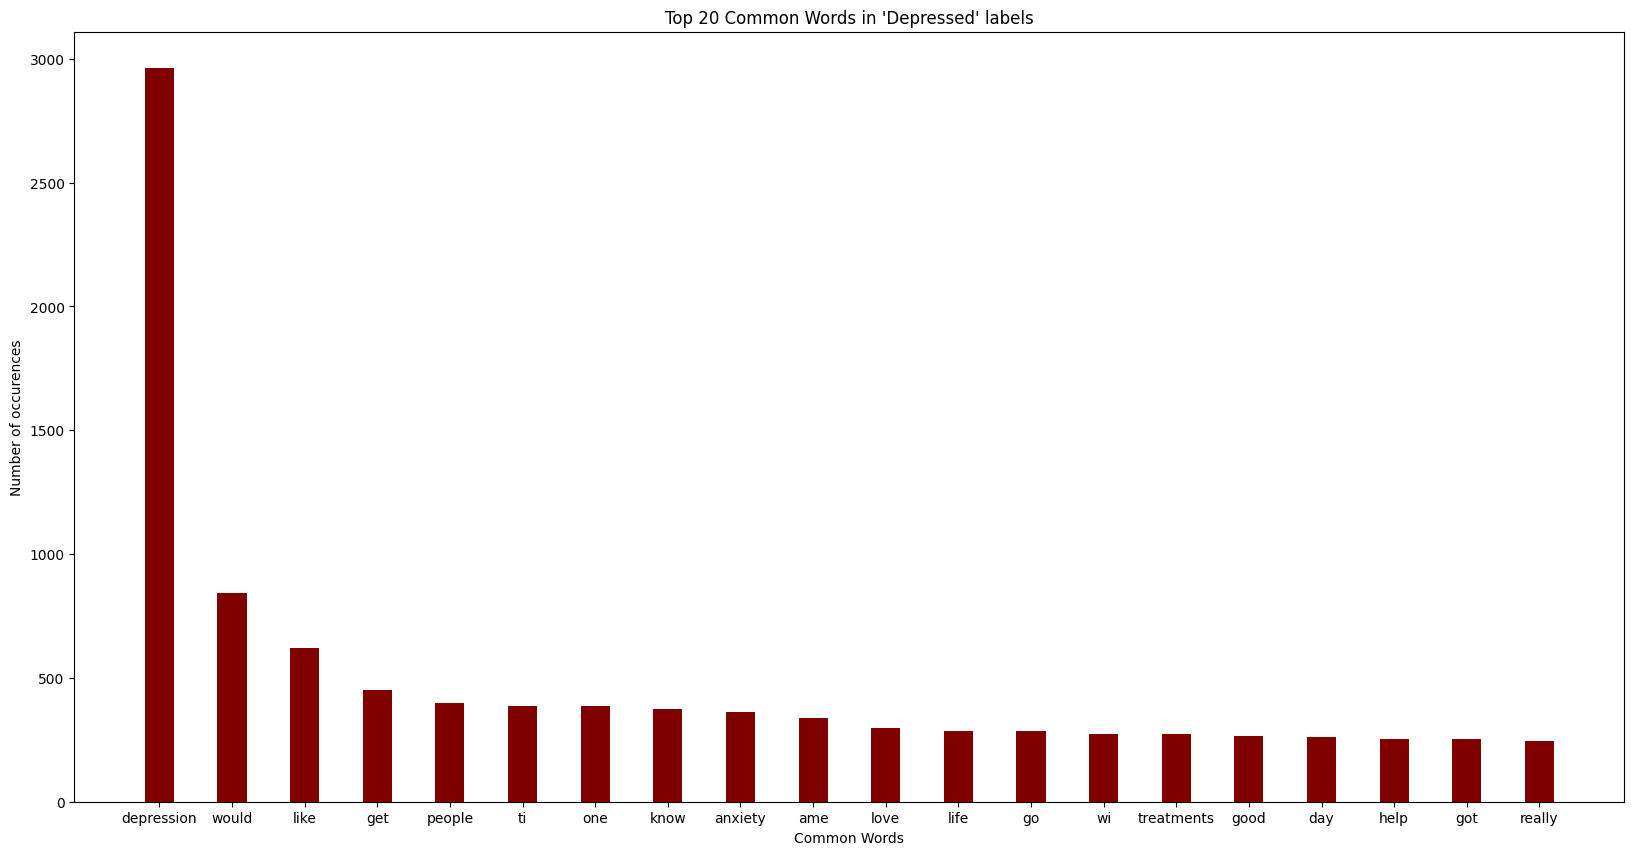

In [88]:
## Visualise in Bar Graph (Popular Words in depressed label)
import matplotlib.pyplot as plt

depressed_words_df = popular_words(df_uncleaned_depressed['Message'])
# depressed_words_df = temp_df.groupby('Common_words').sum().sort_values(by='count',ascending=False)

depressed_words_df
# courses = list(depressed_words_df.keys())
# values = list(depressed_words_df.values())

common_words_list = []
count_list = []

for index, row in depressed_words_df.iterrows():
    common_words_list.append(row['Common_words'])
    count_list.append(row['count'])
    

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(common_words_list, count_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Top 20 Common Words in 'Depressed' labels")
plt.show()


**Insights**: After taking a deeper look at only depressed labelled tweets, we are able to notice extra words such as "treatments" and "help" to name a few. We are able to also observe that there are many words that are common in the whole dataset also appear for the most common words of depressed labelled tweets. However, some of these words may also appear in non depressed label tweets. Therefore, further filtering can be done to find out the most common words that strictly only appear for depressed labelled tweets to ensure only words representative of the label is extracted.

> Getting the most popular words for the whole dataset for non-depressed labelled tweets

In [89]:
# Find Common Words in non-depressed labels (To see if they are overlaps)
df_uncleaned_nondepressed =df_uncleaned[df_uncleaned["Label"] == 0] 
df_uncleaned_nondepressed.shape

(16114, 3)

In [90]:
# function for checking popular words in non-depressed labels:
def popular_words(series):
#     data1['temp_list'] = series.apply(lambda x:str(x).split())
    top = Counter([item for sublist in df_uncleaned_nondepressed['Tokenised'] for item in sublist])
    temp = pd.DataFrame(top.most_common(20))
    temp.columns = ['Common_words','count']
    return temp

popular_words(df_uncleaned_nondepressed['Message'])

,Common_words,count
0,would,1297
1,good,778
2,like,734
3,ame,658
4,love,656
5,ti,608
6,wi,582
7,day,559
8,one,546
9,know,528


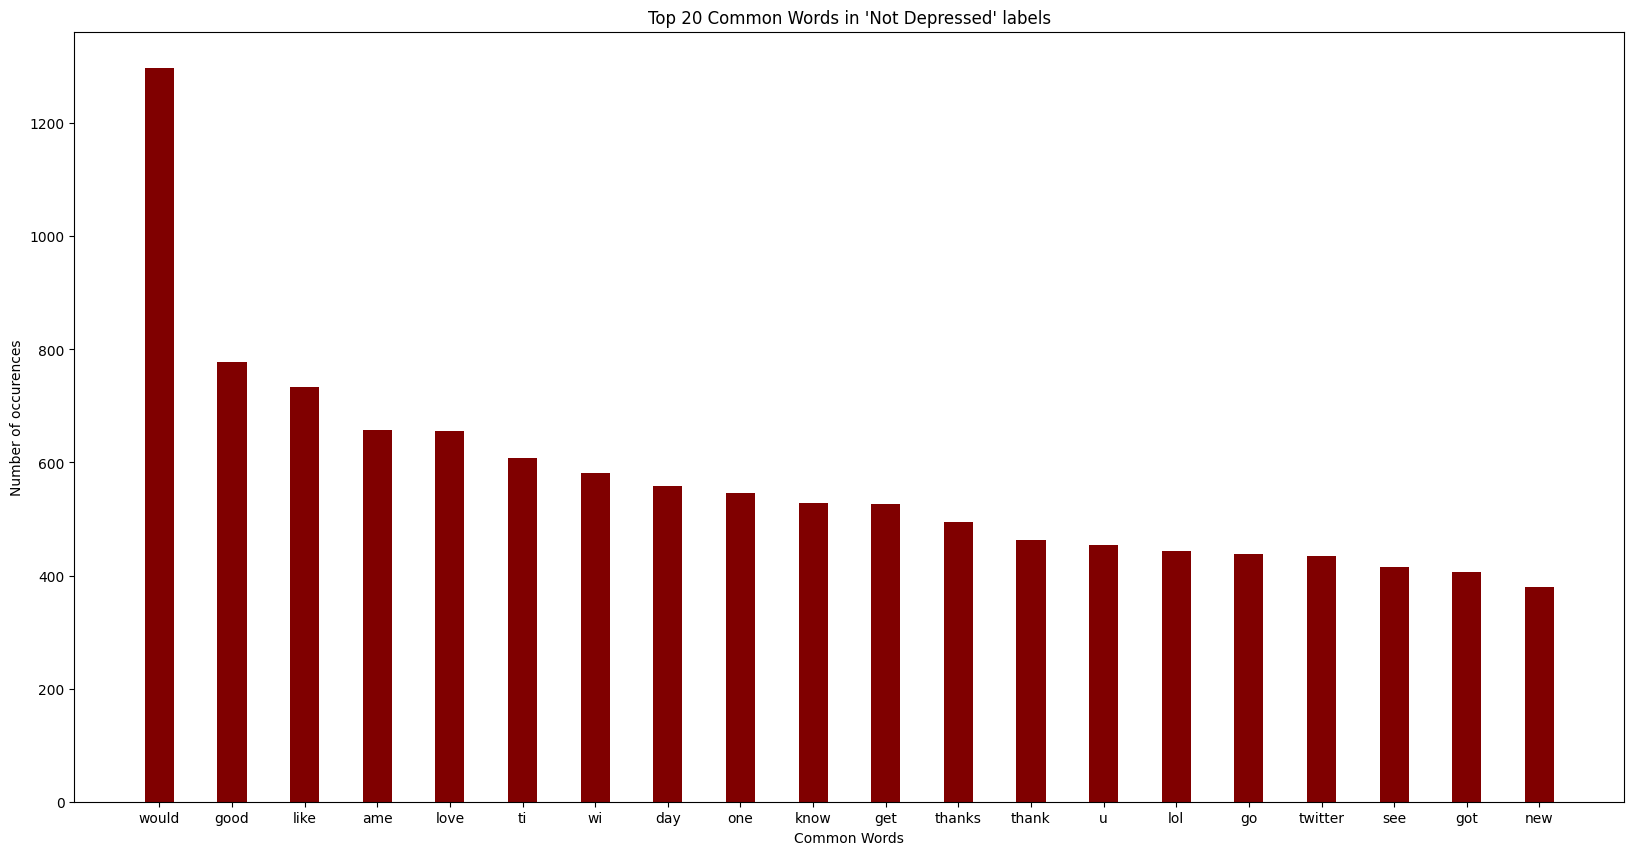

In [91]:
nondepressed_words_df = popular_words(df_uncleaned_nondepressed['Message'])
nondepressed_words_df

common_words_list = []
count_list = []

for index, row in nondepressed_words_df.iterrows():
    common_words_list.append(row['Common_words'])
    count_list.append(row['count'])
    

fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(common_words_list, count_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Top 20 Common Words in 'Not Depressed' labels")
plt.show()

**Insights**: Looking at the common words in the non depressed label tweets, we are able to see words like "would" and "like" which appears in both depressed and non depressed label tweets. We need to filter any other words that may exist in both labels to ensure that we can extract the unique common words of the depressed label tweets.

> Getting the most common unique words for depressed labelled tweets (top words that only appears in depressed labelled tweets)

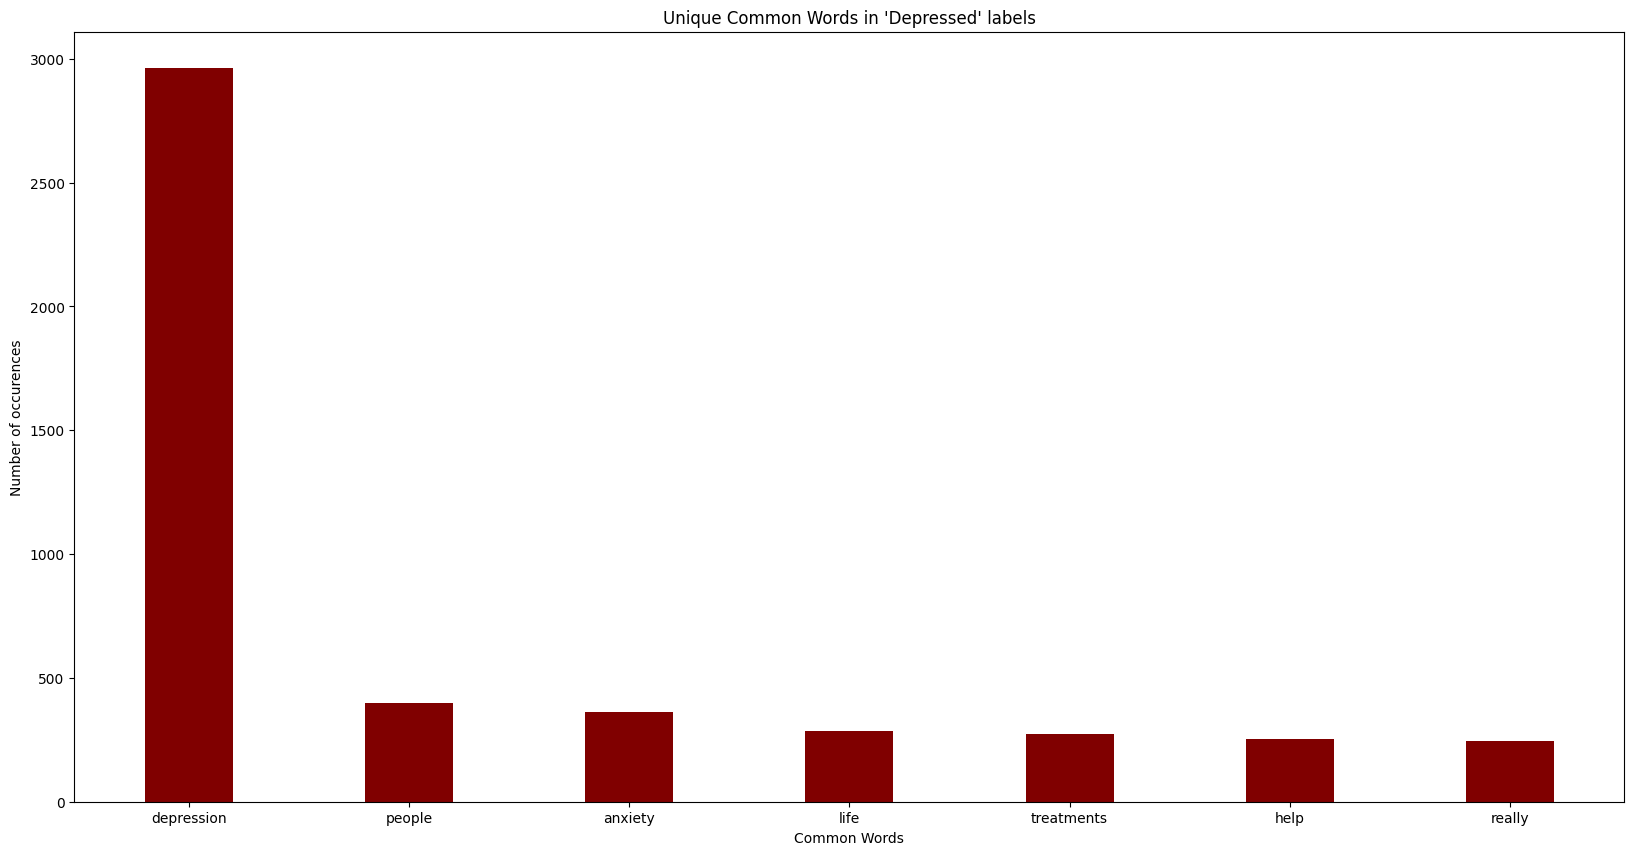

In [92]:
#Find common words in depressed labels that do not appear in non depressed labels

# Depressed dataframe
depressed_words_df

depressed_words = []
depressed_count = []

for index, row in depressed_words_df.iterrows():
    depressed_words.append(row['Common_words'])
    depressed_count.append(row['count'])

# Non Depressed dataframe
nondepressed_words_df

nondepressed_words = []
nondepressed_count = []

for index, row in nondepressed_words_df.iterrows():
    nondepressed_words.append(row['Common_words'])
    nondepressed_count.append(row['count'])


unique_depressed_words = []
unique_depressed_count = []

for i in range(len(depressed_words)):
    if depressed_words[i] not in nondepressed_words:
        unique_depressed_words.append(depressed_words[i])
        unique_depressed_count.append(depressed_count[i])

        
# Plot Bar Graph
fig = plt.figure(figsize = (20, 10))
 
# creating the bar plot
plt.bar(unique_depressed_words, unique_depressed_count, color ='maroon',
        width = 0.4)
 
plt.xlabel("Common Words")
plt.ylabel("Number of occurences")
plt.title("Unique Common Words in 'Depressed' labels")
plt.show()

**Insights**: After obtaining the unique words for the depressed label tweets, we are able to identify 8 unique words that only exist in the depressed labelled tweets.

<hr>

### 5. Preparing Dataset for Model Training


In [93]:
df_uncleaned.head()

,Message,Label,Tokenised
0,real good moment miss hi much,0,"[real, good, moment, missssssssss, hi, much]"
1,reading manga,0,"[reading, manga]"
2,,0,[]
3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0,"[need, send, em, accountant, tomorrow, oddly, even, referring, taxes, supporting, evi, wouldence, though]"
4,add myspace myspacecomlookthunder,0,"[add, myspace, myspacecomlookthunder]"


In [94]:
df_cleaned = df_uncleaned[["Message","Label"]]

In [95]:
df_cleaned.reset_index(inplace=True)

In [96]:
df_cleaned.head()

,index,Message,Label
0,0,real good moment miss hi much,0
1,1,reading manga,0
2,2,,0
3,3,need send em accountant tomorrow oddly even refer tax support evi wouldence though,0
4,4,add myspace myspacecomlookthunder,0


In [97]:
df_cleaned.shape

(26609, 3)

In [98]:
list_of_index = df_cleaned[df_cleaned['Message'] == ''].index.values.tolist()
print(f'number of row with empty string: {len(list_of_index)}')

number of row with empty string: 147


In [99]:
df_cleaned.iloc[list_of_index]

,index,Message,Label
2,2,,0
156,156,,0
263,263,,0
526,526,,0
718,718,,0
778,778,,0
809,809,,0
1233,1233,,0
1461,1461,,0
1480,1480,,0


##### Drop row with empty string

In [100]:
df_cleaned.drop(index=list_of_index, inplace = True)

/common/home/users/j/jianyi.lye.2020/jupyterlab-venv-tf/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [101]:
df_cleaned.shape

(26462, 3)

<hr>

In [102]:
X = df_cleaned.Message
y = df_cleaned.Label

In [103]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

###### convert text to vectors

<hr>

### ELMo


explanation of ELMo here

#### ELMo embedding

In [109]:
# pip uninstall tensorflow

In [110]:
# pip install --upgrade pip

In [111]:
# pip install tensorflow==1.15.0
# df_cleaned

In [112]:
## ELMo not supported for TF >= 2.0
# !pip uninstall tensorflow -y
# !pip uninstall tensorflow-cloud -y
# !pip install -U tensorflow==1.15

In [113]:
# !pip uninstall pytorch-lightning -y
# !pip uninstall tensorflow-probability -y

In [114]:
# pip install tensorflow_hub


In [115]:
#For ELMo word embeddings
import tensorflow_hub as hub
import tensorflow as tf

## Solution: https://www.datasciencelearner.com/attributeerror-module-tensorflow-has-no-attribute-session/
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# elmo = hub.load("https://tfhub.dev/google/elmo/2")
elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

def ELMoEmbedding(data):
#     embed=elmo(data,signature="default",as_dict=True)["elmo"]
    embed = elmo(tf.constant(data))["elmo"]  #, signature="default", as_dict=True)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        out_x=sess.run(embed)
        #out_y=ses.run(tf.reduce_mean(embed,1))
        return out_x


Instructions for updating:
non-resource variables are not supported in the long term


INFO:absl:Using /common/home/users/j/jianyi.lye.2020/tmp/tfhub_modules to cache modules.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2023-04-01 02:41:21.984839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-01 02:41:21.985581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:05:00.0
2023-04-01 02:41:21.988218: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/cuDNN/8.1.1.33-CUDA-11.2.2/lib:/opt/apps/software/CUDA/11.2.2/nvvm/lib64:/opt/apps/software/CUDA/11.2.2/extras/CUPTI/lib64:/opt/apps/software/CUDA/11.2.2/lib:/opt/apps/software/Python/3.7.13-GCCcore-11.2.0/lib:/opt/apps/software/OpenSSL/1.1/lib:/opt/apps/software/libffi/3.4.2-GCCcore-11.2.0

In [116]:
%%time
df_depressed = df_cleaned[df_cleaned['Label'] == 1]
df_nondepressed = df_cleaned[df_cleaned['Label'] == 0]

tweets_list_1 = df_depressed['Message'].iloc[:2500].tolist()
tweets_list_2 = df_nondepressed['Message'].iloc[:2500].tolist()
tweets_list = tweets_list_1 + tweets_list_2


tweets_elmo_embedding=ELMoEmbedding(tweets_list)

tweets_elmo_embedding.shape

2023-04-01 02:41:23.212979: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-04-01 02:41:23.219671: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2194900000 Hz
2023-04-01 02:41:23.220676: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb219760 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-01 02:41:23.220701: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-04-01 02:41:23.401444: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x994e390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-01 02:41:23.401489: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-04-01 02:41:23.401604: I tensorflow/core/co

CPU times: user 36min 15s, sys: 1min 13s, total: 37min 29s
Wall time: 9min 34s


(5000, 51, 1024)

In [117]:
df_depressed.drop(columns=["index"], inplace=True)

In [118]:
df_depressed.head()

,Message,Label
8000,lack understand small significannot part cause anxiety depression feel incredibly lonely soooo easy compare easy invali wouldate,1
8001,tell pare nots depression hard get gen x people understand something control ti ame cure walk keep mind busy,1
8002,depression something speak even go also double edge sword love every race even white people do much hate grandma legit white tf hate dislike people though,1
8003,make torti willa fi will pbj depression cure olivia depression,1
8004,gon na need depression med soon rainouts spin equilibrium emoji pout face mother nature mean bth emoji face symbol mouth,1


### ELMo+ Traditional Classifier

In [119]:
# Get messages from dataset
elmo_embeddings_pooled = np.max(tweets_elmo_embedding, axis=1)
X = elmo_embeddings_pooled

# Get label from dataset
y_1 = df_depressed.iloc[:2500]['Label'].values
y_2 = df_nondepressed.iloc[:2500]['Label'].values
y = np.concatenate((y_1, y_2), axis=0)



print(X.shape)
print(y.shape)


(5000, 1024)
(5000,)


### Baseline Models
- https://medium.com/saarthi-ai/elmo-for-contextual-word-embedding-for-text-classification-24c9693b0045

In [120]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [121]:
elmo_baseline_models = []
elmo_baseline_models.append(('Logistic Regression', LogisticRegression(random_state=0)))
elmo_baseline_models.append(('Decision Tree Classifier',DecisionTreeClassifier(random_state=0)))
elmo_baseline_models.append(('Random Forest', RandomForestClassifier(random_state=0)))
elmo_baseline_models.append(('Gradientboost', GradientBoostingClassifier(random_state=345)))
elmo_baseline_models.append(('SVM', SVC()))
elmo_baseline_models.append(('Gaussian NB', GaussianNB()))

In [122]:
%%time
baseline_result = baselinemodel(elmo_baseline_models,  x_train, y_train, x_test, y_test)

In [123]:
baseline_result.sort_values(by=['TEST_ACCURACY', 'F1 SCORE'], ascending=False)

### ELMo Modelling (Deep Learning)

### ELMO + CNN

In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Define the CNN model
class ELMoEmbeddingCNN(nn.Module):
    def __init__(self):
        super(ELMoEmbeddingCNN, self).__init__()
        self.linear = nn.Linear(768, 1024)
        self.conv1 = nn.Conv1d(1024, 128, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv1d(1024, 128, kernel_size=4, stride=1, padding=3)
        self.conv3 = nn.Conv1d(1024, 128, kernel_size=5, stride=1, padding=4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128 * 3, 1)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add the sequence dimension if it's missing
        x = x.permute(0, 2, 1)  # Swap the feature and sequence dimensions
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.max_pool(x1).squeeze()

        x2 = self.conv2(x)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        x2 = self.max_pool(x2).squeeze()

        x3 = self.conv3(x)
        x3 = self.relu(x3)
        x3 = self.dropout(x3)
        x3 = self.max_pool(x3).squeeze()

        x = torch.cat([x1, x2, x3], dim=1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x.squeeze()

In [125]:
# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# Create train and test datasets
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ELMoEmbeddingCNN()
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

In [126]:
from sklearn.metrics import classification_report

# Create a directory for saving the model
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Define a function to calculate metrics and print the classification report
def get_classification_report(data_loader, loader_type):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            outputs = model(batch_x)
            predictions = (outputs > 0.5).int()
            y_true.extend(batch_y.tolist())
            y_pred.extend(predictions.tolist())

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    print(f"{loader_type} Classification Report (Epoch {epoch+1}):")
    print(classification_report(y_true, y_pred, output_dict=False, zero_division=0))
    return report

# Train the model and calculate metrics for each epoch
num_epochs = 10
best_val_loss = float("inf")
best_epoch = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item() * batch_x.size(0)

    val_loss /= len(val_loader.dataset)
    
    # Print the classification reports for training and validation sets
    train_report = get_classification_report(train_loader, "Train")
    print(f"Epoch [{epoch+1}/{num_epochs}] Val Loss: {val_loss:.4f}")
    val_report = get_classification_report(val_loader, "Validation")
    
    # Save the model with the best validation accuracy
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), os.path.join(model_dir, "best_ELMo_+_CNN_model.pt"))
        print(f"Model saved for epoch {best_epoch}")    
print(f"Best model saved at epoch {best_epoch} with validation loss {best_val_loss:.4f}")

Epoch [1/10] Train Loss: 0.5485
Train Classification Report (Epoch 1):
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.84      1493
         1.0       0.81      0.95      0.87      1507

    accuracy                           0.86      3000
   macro avg       0.87      0.86      0.86      3000
weighted avg       0.87      0.86      0.86      3000

Epoch [1/10] Val Loss: 0.4831
Validation Classification Report (Epoch 1):
              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85       373
         1.0       0.81      0.96      0.88       377

    accuracy                           0.86       750
   macro avg       0.88      0.86      0.86       750
weighted avg       0.88      0.86      0.86       750

Model saved for epoch 1
Epoch [2/10] Train Loss: 0.3790
Train Classification Report (Epoch 2):
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      14

In [127]:
# Load the best model
model.load_state_dict(torch.load(os.path.join(model_dir, "best_ELMo_+_CNN_model.pt")))

# Define a function to calculate metrics and print the classification report
def get_classification_report(data_loader, loader_type):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            outputs = model(batch_x)
            predictions = (outputs > 0.5).int()
            y_true.extend(batch_y.tolist())
            y_pred.extend(predictions.tolist())

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    print(f"{loader_type} Classification Report:")
    print(classification_report(y_true, y_pred, output_dict=False, zero_division=0))
    return report



In [128]:
# Print the classification report for the test dataset
test_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item() * batch_x.size(0)

test_loss /= len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")
test_report = get_classification_report(test_loader, "Test")

Test Loss: 0.2416
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       634
         1.0       0.93      0.91      0.92       616

    accuracy                           0.92      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.92      0.92      0.92      1250



### ELMO + RNN

In [129]:
class ElmoEmbedding:
    def __init__(self):
        self.elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

    def elmo_vectors(self,x):
        embed = self.elmo(tf.constant(x))["elmo"]
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            out_x=sess.run(embed)
            return out_x

In [130]:
# Take a subset of the dataset
messages_1 = df_depressed['Message'].iloc[:2500].values
messages_2 = df_nondepressed['Message'].iloc[:2500].values
messages = np.concatenate((messages_1, messages_2), axis=0)

labels_1 = df_depressed.iloc[:2500]['Label'].values
labels_2 = df_nondepressed.iloc[:2500]['Label'].values
labels = np.concatenate((labels_1, labels_2), axis=0)

# Call the Elmo Class
elmo = ElmoEmbedding()
# Convert text data to ELMo embeddings
X = elmo.elmo_vectors(messages)
y = labels


# tmp = MathOperations()
# print tmp.testAddition(2,3)

2023-04-01 02:53:56.215697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-04-01 02:53:56.215771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-04-01 02:54:02.452165: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 45957120000 exceeds 10% of system memory.


In [131]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [132]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)


(3750, 51, 1024)
(1250, 51, 1024)


In [133]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras import layers
from tensorflow.keras.utils import to_categorical


# input_shape = (X_train.shape[1], X_train.shape[2])

max_len = X_train.shape[1]
embedding_size = X_train.shape[2]

# Convert the labels to one-hot encoding
y_encoded= to_categorical(y_train)

y_encoded

num_classes = y_encoded.shape[1]

Using TensorFlow backend.


In [135]:
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

model = Sequential()
model.add(LSTM(units=64, input_shape=(max_len, embedding_size)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


# Compile the model
optimizer = Adam(lr=5e-5, epsilon=1e-8)
model.compile(loss=binary_crossentropy, optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(X_train, y_encoded, epochs=10, batch_size=32, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3000 samples, validate on 750 samples
Epoch 1/10



2023-04-01 03:06:47.149465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:05:00.0
2023-04-01 03:06:47.150034: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/cuDNN/8.1.1.33-CUDA-11.2.2/lib:/opt/apps/software/CUDA/11.2.2/nvvm/lib64:/opt/apps/software/CUDA/11.2.2/extras/CUPTI/lib64:/opt/apps/software/CUDA/11.2.2/lib:/opt/apps/software/Python/3.7.13-GCCcore-11.2.0/lib:/opt/apps/software/OpenSSL/1.1/lib:/opt/apps/software/libffi/3.4.2-GCCcore-11.2.0/lib64:/opt/apps/software/GMP/6.2.1-GCCcore-11.2.0/lib:/opt/apps/software/XZ/5.2.5-GCCcore-11.2.0/lib:/opt/apps/software/SQLite/3.36-GCCcore-11.2.0/lib:/opt/apps/software/Tcl/8.6.11-GCCcore-11.2.0/lib:/opt/apps/software/li

3000/3000 [==============================] - 7s 2ms/step - loss: 0.6934 - acc: 0.5050 - val_loss: 0.6937 - val_acc: 0.4960
Epoch 2/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6943 - acc: 0.4953 - val_loss: 0.6928 - val_acc: 0.5040
Epoch 3/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6943 - acc: 0.4913 - val_loss: 0.6922 - val_acc: 0.5040
Epoch 4/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.6913 - acc: 0.5180 - val_loss: 0.6833 - val_acc: 0.6187
Epoch 5/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.5608 - acc: 0.7210 - val_loss: 0.2874 - val_acc: 0.9160
Epoch 6/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2559 - acc: 0.9237 - val_loss: 0.1989 - val_acc: 0.9427
Epoch 7/10
3000/3000 [==============================] - 6s 2ms/step - loss: 0.2012 - acc: 0.9413 - val_loss: 0.2037 - val_acc: 0.9320
Epoch 8/10
3000/3000 [==============================] - 6s 2ms/step - los

In [136]:
# Convert the labels to one-hot encoding
y_encoded= to_categorical(y_test)

y_encoded.shape

(1250, 2)

In [137]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_encoded)
print('Test loss:', test_loss)

# Get predictions for the test set
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_encoded, axis=1)

# Generate classification report
print('Test Classification Report:')
print(classification_report(y_true_labels, y_pred_labels))


1250/1250 [==============================] - 1s 642us/step
Test loss: 0.2745239432297647
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       634
           1       0.94      0.89      0.92       616

    accuracy                           0.92      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.92      0.92      0.92      1250



### ELMo + LSTM

In [138]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# class ElmoEmbedding:
#     def __init__(self):
#         self.elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

#     def elmo_vectors(self,x):
#         embed = self.elmo(tf.constant(x))["elmo"]
#         with tf.Session() as sess:
#             sess.run(tf.global_variables_initializer())
#             sess.run(tf.tables_initializer())
#             out_x=sess.run(embed)
#             return out_x

class ELMoLSTMModel:
    def __init__(self, input1, input2):
        
        # Define the LSTM model architecture
        self.model = Sequential()
        self.model.add(LSTM(128, input_shape=(input1, input2)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation="sigmoid"))

    def compile_model(self):
        self.optimizer = Adam(lr=5e-5, epsilon=1e-8)
        self.model.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=["accuracy"])

    def train_model(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print('Test loss:', test_loss)

    def predict(self, X_new):
        # Make a prediction for a new input
        prediction = self.model.predict(X_new)
        return prediction


In [139]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [140]:
# Initialize the model, loss function, and optimizer
model = ELMoLSTMModel(X_train.shape[1],X_train.shape[2])
model.compile_model()
batch_size = 10
epochs = 32
model.train_model(X_train, y_train, X_val, y_val, batch_size, epochs)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 10s 3ms/step - loss: 0.6958 - acc: 0.4947 - val_loss: 0.6930 - val_acc: 0.5027
Epoch 2/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6928 - acc: 0.5083 - val_loss: 0.6930 - val_acc: 0.5027
Epoch 3/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.6905 - acc: 0.5343 - val_loss: 0.6817 - val_acc: 0.6187
Epoch 4/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.4670 - acc: 0.7783 - val_loss: 0.2390 - val_acc: 0.9320
Epoch 5/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.2255 - acc: 0.9320 - val_loss: 0.2039 - val_acc: 0.9373
Epoch 6/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1940 - acc: 0.9440 - val_loss: 0.1893 - val_acc: 0.9387
Epoch 7/10
3000/3000 [==============================] - 9s 3ms/step - loss: 0.1835 - acc: 0.9473 - val_loss: 0.1975 - val_acc: 0.9400
Epoch 8/10
300

In [141]:
from sklearn.metrics import classification_report

# Assuming you have a trained model instance named `model` and test data named `X_test` and `y_test`
model.evaluate_model(X_test, y_test)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
print('Test Classification Report:')
print(classification_report(y_test, y_pred))

1250/1250 [==============================] - 1s 955us/step
Test loss: 0.2745239432297647
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       634
           1       0.98      0.87      0.92       616

    accuracy                           0.92      1250
   macro avg       0.93      0.92      0.92      1250
weighted avg       0.93      0.92      0.92      1250



### ELMO + Bi-LSTM

In [142]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# class ElmoEmbedding:
#     def __init__(self):
#         self.elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

    
#     def elmo_vectors(self,x):
#     #     embed=elmo(data,signature="default",as_dict=True)["elmo"]
#         embed = self.elmo(tf.constant(x))["elmo"]  #, signature="default", as_dict=True)
#         with tf.Session() as sess:
#             sess.run(tf.global_variables_initializer())
#             sess.run(tf.tables_initializer())
#             out_x=sess.run(embed)
#             return out_x

class BiLSTMModel:
    def __init__(self, input1, input2):
        
        # Define the BiLSTM model architecture
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128), input_shape=(input1, input2)))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation="sigmoid"))

    def compile_model(self):
        self.optimizer = Adam(lr=5e-5, epsilon=1e-8)
        self.model.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=["accuracy"])

    def train_model(self, X_train, y_train, X_val,y_val, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print('Test loss:', test_loss)
    
    def predict(self, X_new):
        # Make a prediction for a new input
        prediction = self.model.predict(X_new)
        return prediction

In [143]:
# # Take a subset of the dataset
# messages_1 = df_depressed['Message'].iloc[:2500].values
# messages_2 = df_nondepressed['Message'].iloc[:2500].values
# messages = np.concatenate((messages_1, messages_2), axis=0)

# labels_1 = df_depressed.iloc[:2500]['Label'].values
# labels_2 = df_nondepressed.iloc[:2500]['Label'].values
# labels = np.concatenate((labels_1, labels_2), axis=0)

# # Call the Elmo Class
# elmo = ElmoEmbedding()
# # Convert text data to ELMo embeddings
# X = elmo.elmo_vectors(messages)
# y = labels


# # tmp = MathOperations()
# # print tmp.testAddition(2,3)

In [144]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [145]:
# Initialize the model, loss function, and optimizer
model = BiLSTMModel(X_train.shape[1],X_train.shape[2])
model.compile_model()
batch_size = 10
epochs = 32
model.train_model(X_train, y_train, X_val,y_val, batch_size, epochs)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.5521 - acc: 0.7840 - val_loss: 0.4013 - val_acc: 0.8960
Epoch 2/10
3000/3000 [==============================] - 20s 7ms/step - loss: 0.2917 - acc: 0.9153 - val_loss: 0.2121 - val_acc: 0.9387
Epoch 3/10
3000/3000 [==============================] - 17s 6ms/step - loss: 0.2010 - acc: 0.9317 - val_loss: 0.1797 - val_acc: 0.9453
Epoch 4/10
3000/3000 [==============================] - 23s 8ms/step - loss: 0.1731 - acc: 0.9387 - val_loss: 0.1687 - val_acc: 0.9453
Epoch 5/10
3000/3000 [==============================] - 18s 6ms/step - loss: 0.1599 - acc: 0.9437 - val_loss: 0.1648 - val_acc: 0.9453
Epoch 6/10
3000/3000 [==============================] - 22s 7ms/step - loss: 0.1458 - acc: 0.9493 - val_loss: 0.1610 - val_acc: 0.9467
Epoch 7/10
3000/3000 [==============================] - 23s 8ms/step - loss: 0.1360 - acc: 0.9520 - val_loss: 0.1653 - val_acc: 0.9453
Epoch 8/

In [146]:
from sklearn.metrics import classification_report

# Assuming you have a trained model instance named `model` and test data named `X_test` and `y_test`
model.evaluate_model(X_test, y_test)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten()
print(classification_report(y_test, y_pred))

1250/1250 [==============================] - 3s 2ms/step
Test loss: 0.2745239432297647
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       634
           1       0.96      0.89      0.92       616

    accuracy                           0.93      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.93      0.93      0.93      1250

